# Highway Crashes
---

# Long-range Forecasting and Pattern Discovery given Limited Data

In [1]:
# %load setup_bayes.py
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
# import theano
# import theano.tensor as tt
# import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
# from bqplot import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# from beakerx import *
sns.set_context('notebook', font_scale = 1.1)
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 'lines.linewidth': 2.0, 
      'lines.markersize': 8, 'font.family': "serif", 'font.serif': "cm", 'savefig.dpi': 200,
      'text.usetex': False, 'legend.fontsize': 20.0, 'axes.titlesize': 20, "figure.figsize": [20, 12]}
sns.set(rc = rc)
sns.set_style("ticks")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gpflow
from gpflowopt.domain import ContinuousParameter
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.acquisition import ExpectedImprovement, MinValueEntropySearch
from gpflowopt.optim import StagedOptimizer, MCOptimizer, SciPyOptimizer  
from gpflowopt.design import LatinHyperCube
import random
random.seed(1234)
from warnings import filterwarnings
filterwarnings("ignore")

/Users/demaasit/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data Preparation

In [2]:
monthly_crash_data = pd.read_csv("../../data/monthly_data.csv")
monthly_crash_data.head()

In [3]:
# Check the data types of each variable
monthly_crash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
Year               240 non-null int64
Month              240 non-null int64
Fatalities         240 non-null int64
SeriousInjuries    240 non-null int64
dtypes: int64(4)
memory usage: 7.6 KB


Create a new datetime column labelled "ds" that combines original columns "Year" and "Month"


In [4]:
from datetime import datetime
monthly_crash_data["ds"] = monthly_crash_data["Year"].map(str) + "-" + monthly_crash_data["Month"].map(str)
monthly_crash_data["ds"] = pd.to_datetime(monthly_crash_data["ds"])
monthly_crash_data["ds"] = monthly_crash_data.ds.astype("O")
monthly_crash_data.tail()

In [5]:
from datetime import datetime
monthly_crash_data["ds"] = monthly_crash_data.apply(lambda x: datetime.date(x["ds"]), axis = 1)

In [6]:
# Check again the data types of each variable
monthly_crash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
Year               240 non-null int64
Month              240 non-null int64
Fatalities         240 non-null int64
SeriousInjuries    240 non-null int64
ds                 240 non-null object
dtypes: int64(4), object(1)
memory usage: 9.5+ KB


In [7]:
fatal_crash_data = monthly_crash_data[["ds", "Fatalities"]].rename(columns = {"Fatalities" : "y"})
fatal_crash_data.head()

visualize fatal crashes

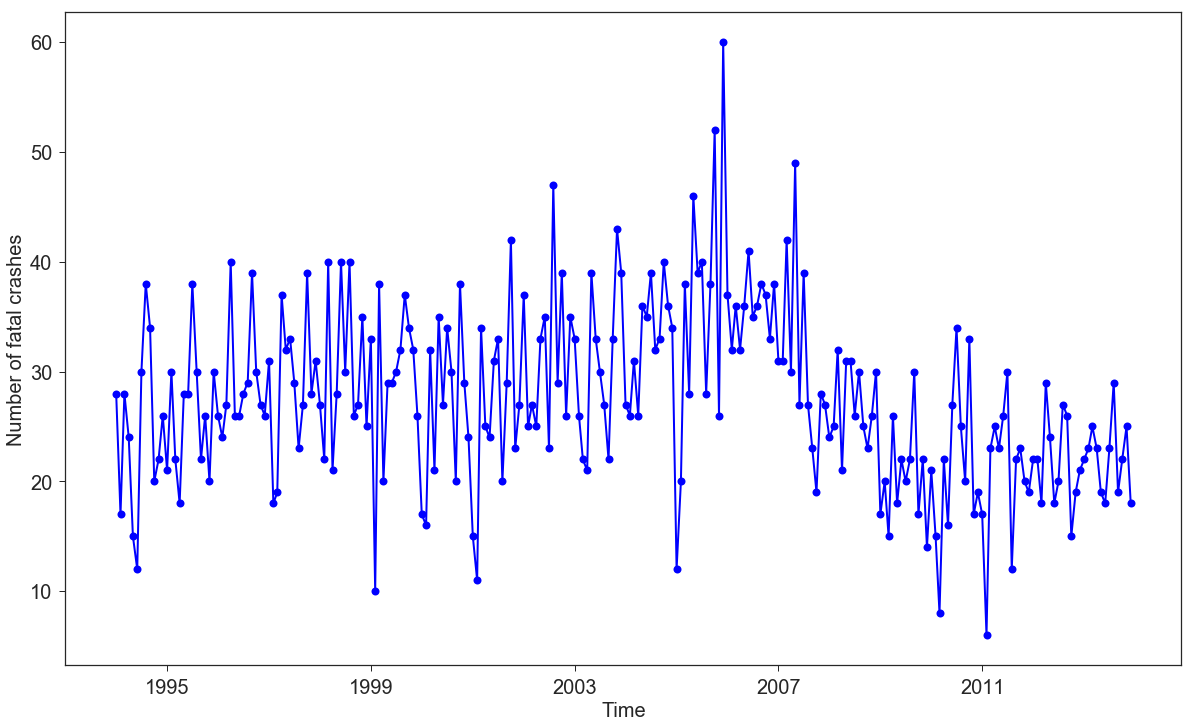

In [8]:
fig, ax = plt.subplots()
ax.plot(fatal_crash_data.ds, fatal_crash_data.y, color = "b", marker = "o")
# ax.set_xticklabels(labels = fatal_crash_data.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of fatal crashes");
# ax.set_title("Number of Fatal Crashes");

In [9]:
injury_crash_data = monthly_crash_data[["ds", "SeriousInjuries"]].rename(columns = {"SeriousInjuries" : "y"})
injury_crash_data.head()

In [10]:
injury_crash_data[injury_crash_data.index == 192]

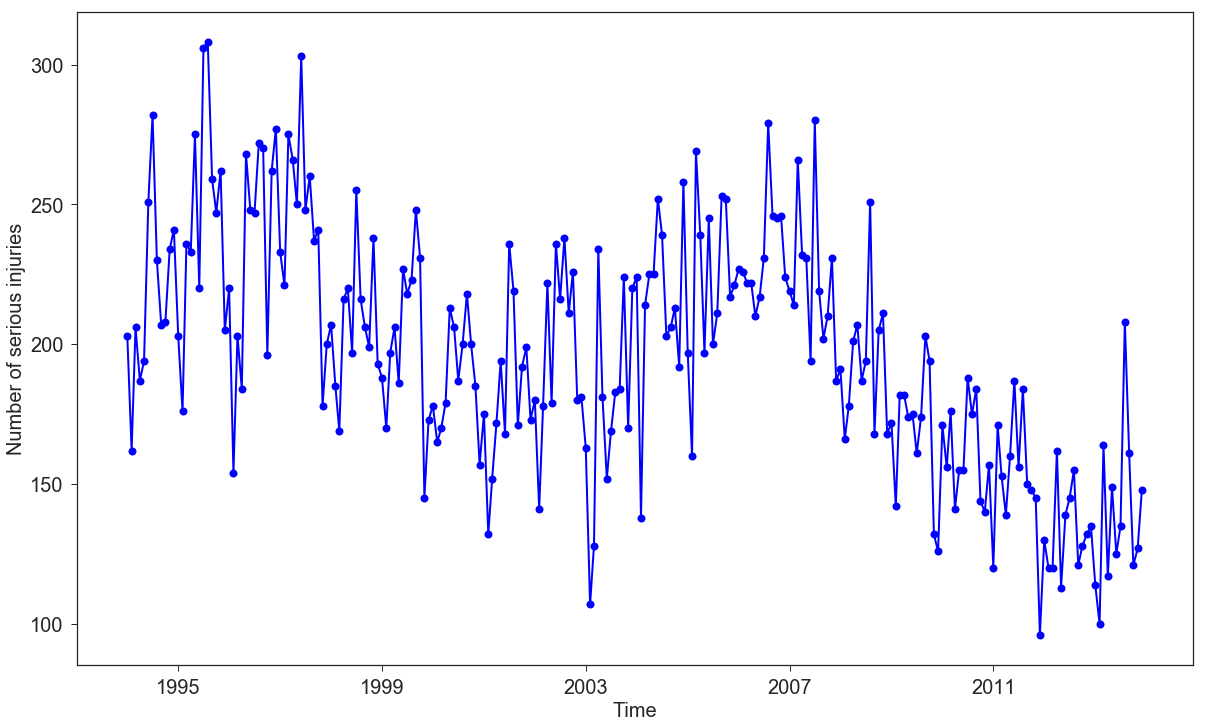

In [11]:
fig, ax = plt.subplots()
ax.plot(injury_crash_data.ds, injury_crash_data.y, color = "b", marker = "o")
# ax.set_xticklabels(labels = injury_crash_data.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of serious injuries");
# ax.set_title("Number of Emails sent Monthly");

Import Yearly crashes per 100 million vehicle miles traveled (VMT)

In [12]:
yearly_data = pd.read_csv("../../data/yearly_data.csv", parse_dates = ["Years"])
yearly_data.tail(n = 10)

In [13]:
groups = monthly_crash_data.groupby(["Year"]).sum().reset_index()
injury_data = groups[["Year", "SeriousInjuries"]].rename(columns = {"Year": "Years"})
vmt = pd.read_csv("../../data/yearly_data.csv")[["Years", "VMT(Billions)"]]
injury_data = injury_data.merge(vmt)
injury_data["y"] = injury_data["SeriousInjuries"]/(injury_data["VMT(Billions)"]*10)
injury_data["ds"] = pd.to_datetime(injury_data["Years"].astype(str))
injury_data = injury_data.drop(["Years", "VMT(Billions)", "SeriousInjuries"], axis = 1)
injury_data

In [14]:
# fatal_data = injury_data

In [15]:
my_date = pd.to_datetime(str(1994), format = "%Y")
my_date

Timestamp('1994-01-01 00:00:00')

In [16]:
fatal_data = yearly_data[["Years", "VMT(Billions)", "Fatalities"]]
fatal_data["y"] = fatal_data["Fatalities"]/(fatal_data["VMT(Billions)"]*10)
fatal_data["ds"] = fatal_data.apply(lambda x: datetime.date(x["Years"]), axis = 1)
fatal_data = fatal_data.drop(["Years", "VMT(Billions)", "Fatalities"], axis = 1)
fatal_data = fatal_data.drop(fatal_data.index[:25]).reset_index().drop(["index"], axis = 1)
fatal_data

In [17]:
fatal_data.describe()

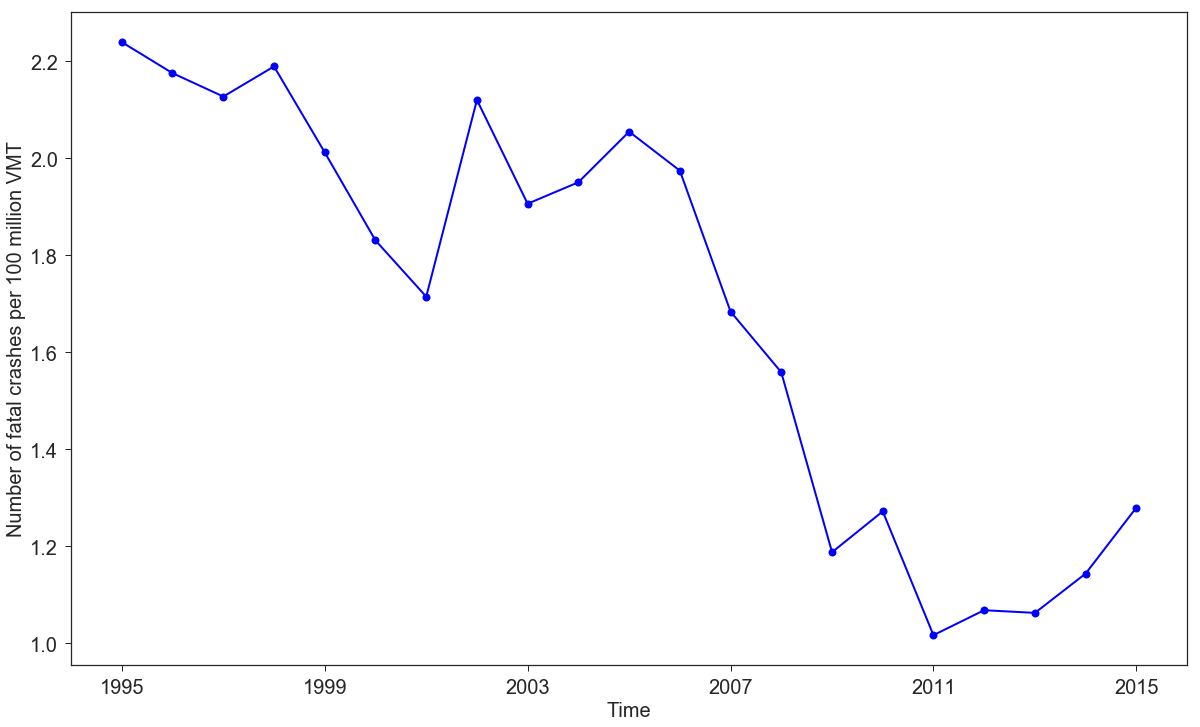

In [18]:
fig, ax = plt.subplots()
ax.plot(fatal_data.ds, fatal_data.y, color = "b", marker = "o")
# ax.set_xticklabels(labels = injury_crash_data.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of fatal crashes per 100 million VMT");
# ax.set_title("Number of Emails sent Monthly");

In [19]:
X_complete = np.array([fatal_data.index]).reshape((fatal_data.shape[0], 1)).astype('float64')
X_train = X_complete[0:15, ]
X_test = X_complete[15:fatal_data.shape[0], ]
Y_complete = np.array([fatal_data.y]).reshape((fatal_data.shape[0], 1)).astype('float64')
Y_train = Y_complete[0:15, ]
Y_test = Y_complete[15:fatal_data.shape[0], ]
D = Y_train.shape[1];

In [20]:
D

1

In [21]:
Y_train.shape; X_train.shape; Y_test.shape; X_test.shape; X_complete.shape

(15, 1)

(15, 1)

(6, 1)

(6, 1)

(21, 1)

In [22]:
Y_train; X_train; X_test; X_complete

array([[ 2.23987405],
       [ 2.17595198],
       [ 2.12765957],
       [ 2.18973675],
       [ 2.01265095],
       [ 1.83116957],
       [ 1.71500355],
       [ 2.12067238],
       [ 1.90663696],
       [ 1.95080996],
       [ 2.05525606],
       [ 1.97489003],
       [ 1.68427707],
       [ 1.55919153],
       [ 1.18803168]])

array([[  0.],
       [  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.],
       [ 11.],
       [ 12.],
       [ 13.],
       [ 14.]])

array([[ 15.],
       [ 16.],
       [ 17.],
       [ 18.],
       [ 19.],
       [ 20.]])

array([[  0.],
       [  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.],
       [ 11.],
       [ 12.],
       [ 13.],
       [ 14.],
       [ 15.],
       [ 16.],
       [ 17.],
       [ 18.],
       [ 19.],
       [ 20.]])

In [23]:
Y_train.dtype

dtype('float64')

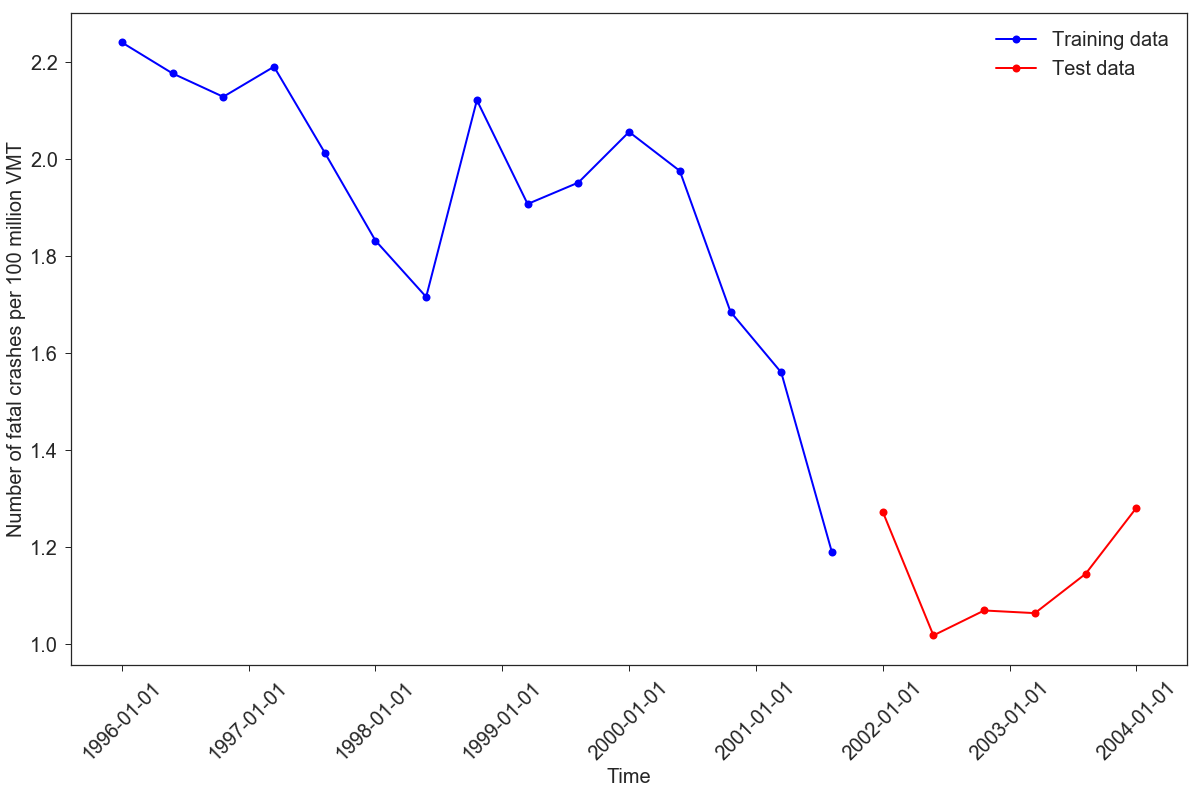

In [24]:
fig, ax = plt.subplots()
ax.plot(X_train.flatten(),Y_train.flatten(), c ='b', marker = "o", label = "Training data")
ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
ax.set_xticklabels(labels = fatal_data.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of fatal crashes per 100 million VMT")
plt.legend(loc = "best");
plt.savefig("results/crashes/VMT/fatalities/data-fatalities.png");
# fig1 = plt.gcf()
# py.offline.iplot_mpl(fig1);

## Gaussian Process modeling

In [25]:
# Trains a model with a spectral mixture kernel, given an ndarray of 
# 2Q frequencies and lengthscales

Q = 10 # nr of terms in the sum
max_iters = 1000

def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]

    kterms = []
    for i in range(Q):
        rbf = gpflow.kernels.RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = gpflow.transforms.Exp()
        cos = gpflow.kernels.Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)

    k = np.sum(kterms) + gpflow.kernels.Linear(D) + gpflow.kernels.Bias(D)
    m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
    return m

m = create_model(np.ones((2*Q,)))

In [26]:
%%time
m.optimize(maxiter = max_iters)

CPU times: user 8.17 s, sys: 453 ms, total: 8.62 s
Wall time: 7.95 s


      fun: 0.022890571939532478
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.77984829e-06,  -7.71045236e-06,  -7.27316898e-10,
        -4.66818947e-08,  -1.86076772e-06,  -5.99348674e-08,
        -7.27316898e-10,  -4.66818947e-08,  -1.86076772e-06,
        -5.99348674e-08,  -7.27316898e-10,  -4.66818947e-08,
        -1.86076772e-06,  -5.99348674e-08,  -7.27316898e-10,
        -4.66818947e-08,  -1.86076772e-06,  -5.99348674e-08,
        -7.27316898e-10,  -4.66818947e-08,  -1.86076772e-06,
        -5.99348674e-08,  -7.27316898e-10,  -4.66818947e-08,
        -1.86076772e-06,  -5.99348674e-08,  -7.27316898e-10,
        -4.66818947e-08,  -1.86076772e-06,  -5.99348674e-08,
        -7.27316898e-10,  -4.66818947e-08,  -1.86076772e-06,
        -5.99348674e-08,  -7.27316898e-10,  -4.66818947e-08,
        -1.86076772e-06,  -5.99348674e-08,  -7.27316898e-10,
        -4.66818947e-08,  -1.86076772e-06,  -5.99348674e-08,
        -6.36836566e-13])
  message: b'CONVER

In [27]:
def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticklabels(labels = fatal_data.ds, rotation = 45)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of fatal crashes per 100 million VMT");
    ax.plot(X_train.flatten(), Y_train.flatten(), c='r', marker = "o", label = 'Training data')
    ax.plot(X_test.flatten(), Y_test.flatten(), c='b', marker = "o", label = 'Test data')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g', marker = "o", label = "Predicted mean function")
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1, label = "95% Predicted Credible interval")
    plt.legend(loc = "best")
    plt.tight_layout()

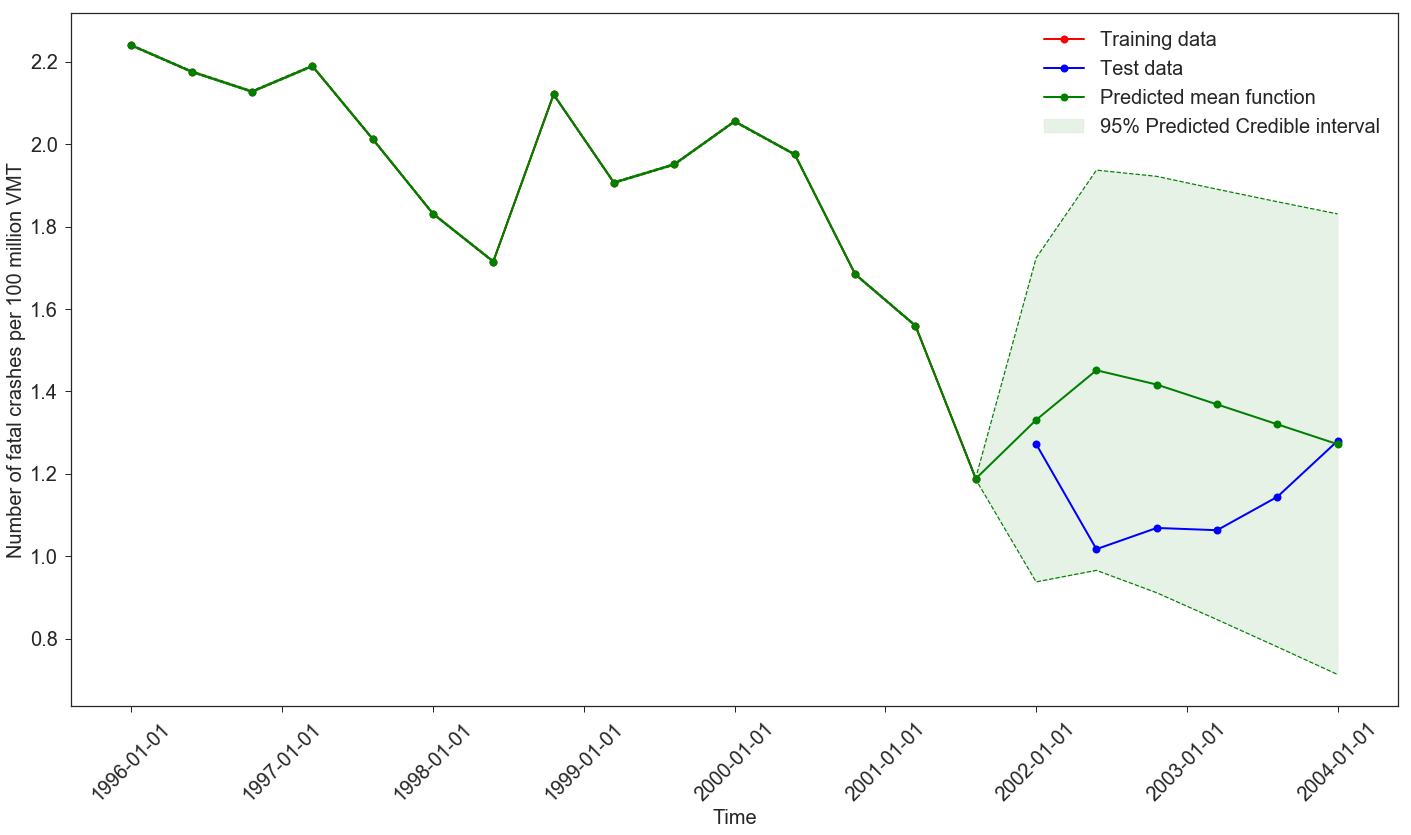

In [28]:
plotprediction(m)
plt.savefig("results/crashes/VMT/fatalities/model-fatalities.png");

In [29]:
## Calculate the RMSE and MAPE
def calculate_rmse(model, X_test, Y_test):
    mu, var = model.predict_y(X_test)
    rmse = np.sqrt(((mu - Y_test)**2).mean())
    return rmse

def calculate_mape(model, X_test, Y_test):
    mu, var = model.predict_y(X_test)
    mape = (np.absolute(((mu - Y_test)/Y_test)*100)).mean()
    return mape

In [50]:
calculate_rmse(model=m, X_test = X_test, Y_test = Y_test)

0.26999355629600635

## Perform hyperparameter tuning using Bayesian Optimization

Let's use Bayesian Optimization to find the optimal model parameters of the GP model and then use then to estimate the model and prediction.

In [31]:
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

Name,Type,Values
freq0,Continuous,[ 0. 5.]
freq1,Continuous,[ 0. 5.]
freq2,Continuous,[ 0. 5.]
freq3,Continuous,[ 0. 5.]
freq4,Continuous,[ 0. 5.]
freq5,Continuous,[ 0. 5.]
freq6,Continuous,[ 0. 5.]
freq7,Continuous,[ 0. 5.]
freq8,Continuous,[ 0. 5.]
freq9,Continuous,[ 0. 5.]


In [32]:
%%time
design = LatinHyperCube(6, domain)
X = design.generate()

CPU times: user 1min 17s, sys: 21.1 s, total: 1min 38s
Wall time: 1min 40s


In [33]:
%%time
Y = objectivefx(X)

CPU times: user 4min 23s, sys: 6.93 s, total: 4min 30s
Wall time: 4min 25s


In [34]:
%%time
k_surrogate = gpflow.kernels.Matern52(input_dim = domain.size, ARD = False)

CPU times: user 219 µs, sys: 1 µs, total: 220 µs
Wall time: 226 µs


In [35]:
%%time
model_surrogate = gpflow.gpr.GPR(X, Y, kern = k_surrogate)

CPU times: user 568 µs, sys: 91 µs, total: 659 µs
Wall time: 616 µs


In [36]:
%%time
acq_fn = ExpectedImprovement(model_surrogate)
# acq_fn = MinValueEntropySearch(model_surrogate, domain = domain)

CPU times: user 1min 26s, sys: 1.94 s, total: 1min 28s
Wall time: 1min 28s


In [37]:
%%time
acq_optimizer = StagedOptimizer([MCOptimizer(domain, nsamples = 5000), 
                                SciPyOptimizer(domain)])

CPU times: user 1.2 ms, sys: 1.23 ms, total: 2.44 ms
Wall time: 1.78 ms


In [38]:
%%time
optimizer = BayesianOptimizer(domain = domain, 
                              acquisition = acq_fn, 
                              optimizer = acq_optimizer)

CPU times: user 21.2 s, sys: 746 ms, total: 22 s
Wall time: 22.1 s


In [ ]:
%%time
with optimizer.silent():
    result = optimizer.optimize(objectivefx = objectivefx, n_iter = 30)

In [40]:
print(result)

     fun: array([-4.69849845])
 message: 'OK'
    nfev: 30
 success: True
       x: array([[   3.07615666,    3.58459957,    3.45322696,    2.42305877,
           4.28729708,    4.84858023,    2.07289418,    2.70546851,
           1.14784669,    0.58956497,   72.22282187,  116.87695899,
         273.9345794 ,  103.05950314,  102.17265278,  294.51400524,
           1.18109004,  292.83392185,  275.95411814,    0.35545735]])


In [41]:
%%time
m_opt = create_model(result.x[0,:])
m_opt.optimize()

CPU times: user 1min 44s, sys: 28.3 s, total: 2min 13s
Wall time: 2min 19s


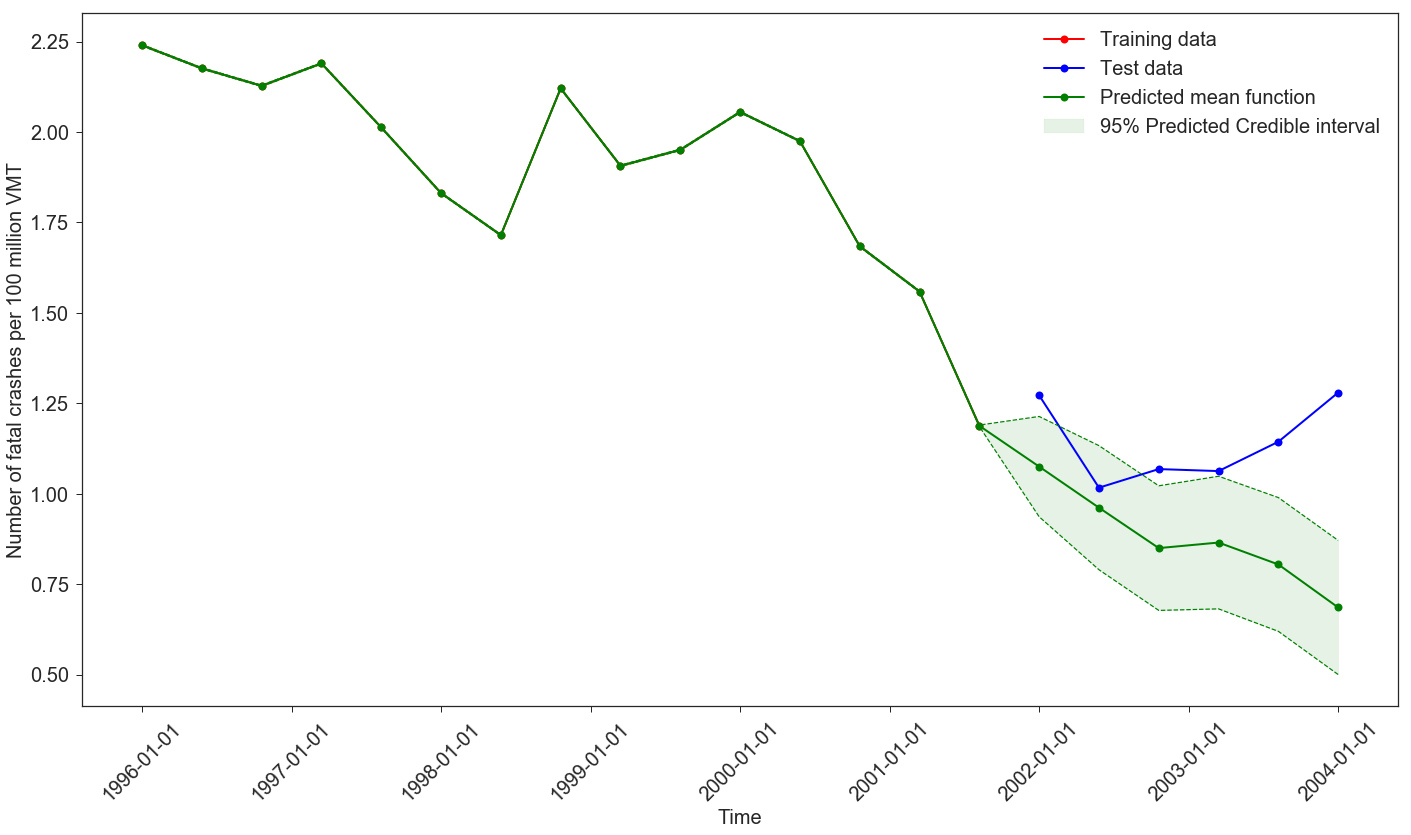

In [51]:
plotprediction(m_opt)
plt.savefig("results/crashes/VMT/fatalities/model-opt-fatalities.png");

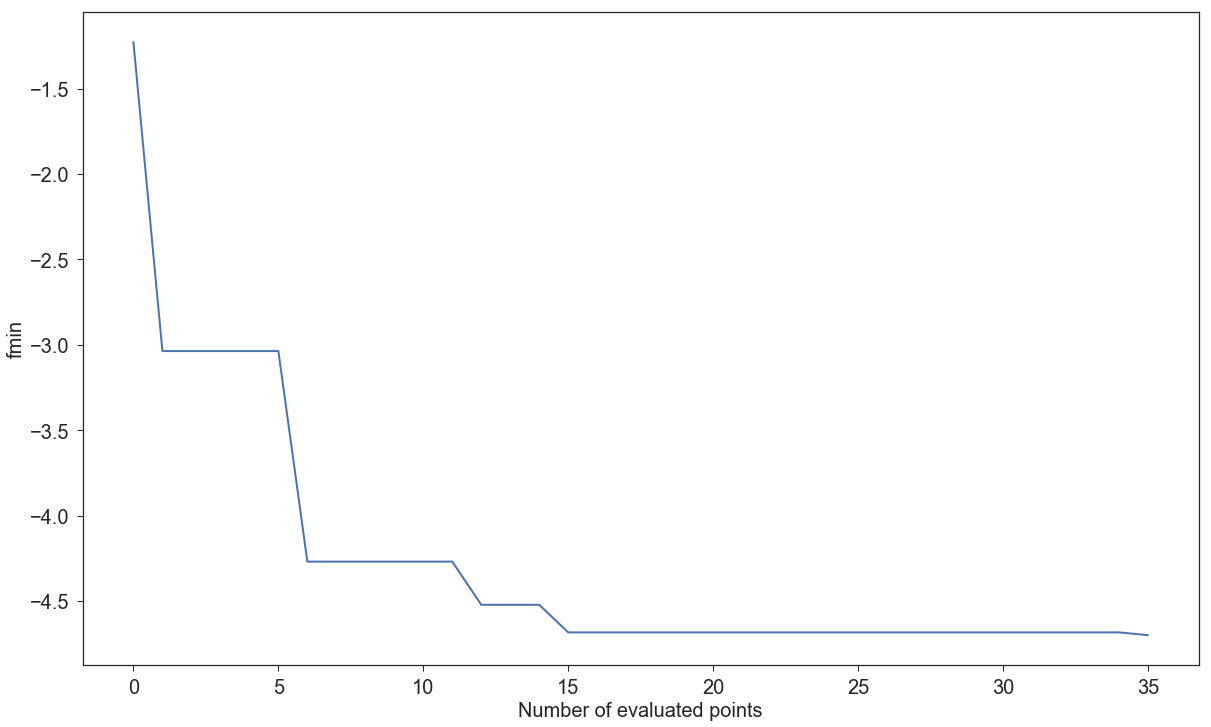

In [45]:
## Inspect the evolution
f, axes = plt.subplots()
f = acq_fn.data[1][:,0]
axes.plot(np.arange(0, acq_fn.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points')
plt.savefig("results/crashes/VMT/fatalities/iterations-fatalities.png");

In [44]:
# # save the model and results to the files 'model.pkl' model_optimized.pkl'
# # and 'results.pkl' for later use
# with open('results/crashes/VMT/fatalities/model2.pkl', 'wb') as mdl:
#     pickle.dump(m, mdl, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('results/crashes/VMT/fatalities/model_optimized2.pkl', 'wb') as mdl_opt:
#     pickle.dump(m_opt, mdl_opt, protocol = pickle.HIGHEST_PROTOCOL)    
    
# with open('results/crashes/VMT/fatalities/result_optimized2.pkl', 'wb') as res:
#     pickle.dump(result, res, protocol = pickle.HIGHEST_PROTOCOL) 
    
# with open('results/crashes/VMT/fatalities/acq_fn2.pkl', 'wb') as acq:
#     pickle.dump(acq_fn, acq, protocol = pickle.HIGHEST_PROTOCOL)  

In [22]:
# # load it at some future point
# with open('results/crashes/VMT/fatalities/model.pkl', 'rb') as mdl:
#     m = pickle.load(mdl)

# with open('results/crashes/VMT/fatalities/model_optimized.pkl', 'rb') as mdl_opt:
#     m_opt = pickle.load(mdl_opt)
    
# with open('results/crashes/VMT/fatalities/result_optimized.pkl', 'rb') as res:
#     result = pickle.load(res)   
    
# with open('results/crashes/VMT/fatalities/acq_fn.pkl', 'rb') as acq:
#     acq_fn = pickle.load(acq)     

In [24]:
# improve quality of figures for journal paper
%config InlineBackend.figure_format = "retina" 

In [81]:
# print system information/setup
%reload_ext watermark
%watermark -v -m -p numpy,pandas,gpflowopt,gpflow,tensorflow,matplotlib,ipywidgets,beakerx,seaborn -g

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
gpflowopt 0.1.0
gpflow 0.4.0
tensorflow 1.4.1
matplotlib 2.1.1
ipywidgets 7.1.1
beakerx 0.12.1
seaborn 0.8.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : e4dd6cd511d5452d6871bdb5d964972707ba3328
